Found 60000 images belonging to 5 classes.
Found 15000 images belonging to 5 classes.
Epoch 1/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 547ms/step - accuracy: 0.8728 - loss: 0.7434
Epoch 1: val_accuracy improved from -inf to 0.67160, saving model to models/best_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1154s 613ms/step - accuracy: 0.8728 - loss: 0.7431 - val_accuracy: 0.6716 - val_loss: 3.5398
Epoch 2/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 576ms/step - accuracy: 0.9593 - loss: 0.1312
Epoch 2: val_accuracy improved from 0.67160 to 0.85040, saving model to models/best_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1210s 645ms/step - accuracy: 0.9593 - loss: 0.1312 - val_accuracy: 0.8504 - val_loss: 0.6776
Epoch 3/3
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 0s 556ms/step - accuracy: 0.9747 - loss: 0.0847
Epoch 3: val_accuracy improved from 0.85040 to 0.97673, saving model to models/best_model.h5


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1162s 619ms/step - accuracy: 0.9747 - loss: 0.0847 - val_accuracy: 0.9767 - val_loss: 0.1589


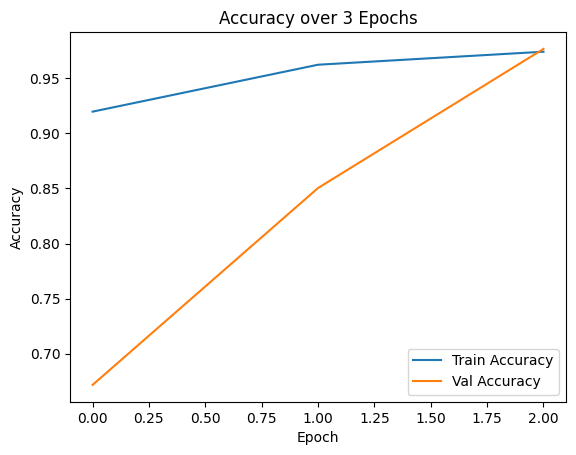

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

# === Paths & Hyperparameters ===
train_dir = r'/Users/sagar/OneDrive/Documents/Desktop/GrainGaurd/data/processed/Rice_Image_Dataset'  
img_height, img_width = 128, 128
batch_size = 32

# === Data Preparation ===
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_data = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

class_names = list(train_data.class_indices.keys())

# === Model Definition ===
model = Sequential([
    Input(shape=(img_height, img_width, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(class_names), activation='softmax')
])

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# === Save Best Model Automatically ===
checkpoint_path = 'models/best_model.h5'
os.makedirs('models', exist_ok=True)
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)

# === Train ===
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=3,
    callbacks=[checkpoint]
)

# === Plot ===
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over 3 Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



Classification Report

              precision    recall  f1-score   support

     Arborio       0.19      0.18      0.18      3000
     Basmati       0.19      0.19      0.19      3000
      Ipsala       0.20      0.21      0.21      3000
     Jasmine       0.19      0.20      0.20      3000
   Karacadag       0.21      0.21      0.21      3000

    accuracy                           0.20     15000
   macro avg       0.20      0.20      0.20     15000
weighted avg       0.20      0.20      0.20     15000

Overall Accuracy : 0.19733333333333333


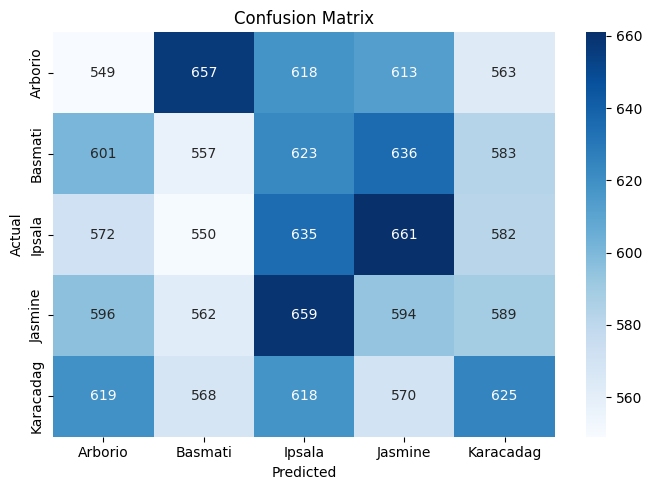

✅  Metrics saved to /reports/


In [7]:
# -------------------------------------------------
# EVALUATION CELL — copy-paste & run
# -------------------------------------------------
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle, json, os

# 1️⃣  Load the best-saved model
best_model = load_model('models/best_model.h5')

# 2️⃣  Get predictions on the validation generator
val_preds   = best_model.predict(val_data, verbose=0)
y_pred      = np.argmax(val_preds, axis=1)
y_true      = val_data.classes
class_dict  = val_data.class_indices
class_names = list(class_dict.keys())

# 3️⃣  Classification metrics
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
print("Classification Report\n")
print(classification_report(y_true, y_pred, target_names=class_names))
print("Overall Accuracy :", accuracy_score(y_true, y_pred))

# 4️⃣  Confusion-matrix heat-map
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.show()

# 5️⃣  (Optional) save metrics for your hackathon report
os.makedirs("reports", exist_ok=True)
with open("reports/classification_report.json","w") as f: json.dump(report, f, indent=2)
pd.DataFrame(cm, index=class_names, columns=class_names).to_csv("reports/confusion_matrix.csv")
print("✅  Metrics saved to /reports/")


In [8]:
import pickle, os
os.makedirs("models", exist_ok=True)
with open("models/history.pkl", "wb") as f:
    pickle.dump(history.history, f)
print("✅  Training history saved.")


✅  Training history saved.


In [9]:
with open("models/history.pkl", "rb") as f:
    hist = pickle.load(f)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
Confidence vector: [2.1964204e-19 1.6536004e-18 1.0000000e+00 2.8883552e-13 0.0000000e+00]


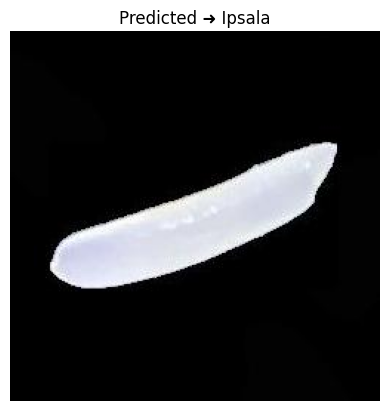

In [10]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt, numpy as np

img_path = "/Users/sagar/OneDrive/Documents/Desktop/GrainGaurd/data/processed/Rice_Image_Dataset/Basmati/basmati (3).jpg"          
img      = image.load_img(img_path, target_size=(128,128))
arr      = image.img_to_array(img)/255.0
arr      = np.expand_dims(arr, axis=0)

pred     = model.predict(arr)
labels   = list(val_data.class_indices.keys())
print("Confidence vector:", pred[0])

predicted_class = labels[np.argmax(pred)]
plt.imshow(image.load_img(img_path)); plt.axis('off')
plt.title(f"Predicted ➜ {predicted_class}")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Confidence vector: [1.0483093e-09 3.1345210e-04 1.2866359e-26 9.9968660e-01 1.2012183e-25]


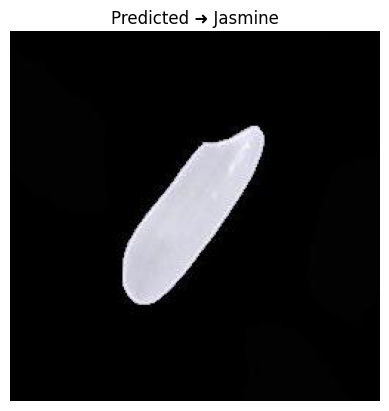

In [11]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt, numpy as np

img_path = "/Users/sagar/OneDrive/Documents/Desktop/GrainGaurd/data/processed/Rice_Image_Dataset/Jasmine/Jasmine (7).jpg"          
img      = image.load_img(img_path, target_size=(128,128))
arr      = image.img_to_array(img)/255.0
arr      = np.expand_dims(arr, axis=0)

pred     = model.predict(arr)
labels   = list(val_data.class_indices.keys())
print("Confidence vector:", pred[0])

predicted_class = labels[np.argmax(pred)]
plt.imshow(image.load_img(img_path)); plt.axis('off')
plt.title(f"Predicted ➜ {predicted_class}")
plt.show()
